In [102]:
import pystac_client
import planetary_computer as pc

#import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import box
from shapely.geometry import Polygon, MultiPolygon
import os

In [2]:
def query_line(line, year):

    date_range = str(year)+'-01-01/'+str(year)+'-12-31'

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1")

    search = catalog.search(
        collections=["naip"], 
        intersects=line, 
        datetime=date_range)
    
    items =list(search.get_items()) 
    if len(items)==0:
        return None
    return items

In [3]:
fp = os.path.join(os.getcwd(),'sb_county_coast','sb_county_coast.shp')
coast = gpd.read_file(fp)
coast

,id,geometry
0,0,"LINESTRING (-118.51632 34.07155, -118.80054 34..."


In [4]:
coast_scenes = query_line(coast.geometry[0],2018)

In [5]:
def make_bbox(item):
    c = item.properties['proj:bbox']
    return box(c[0],c[1],c[2],c[3])

In [6]:
# make dataframe with collected scenes and relevant info
df = pd.DataFrame(coast_scenes, columns = ['item'])
df['date']=df.item.apply(lambda item : item.properties['datetime'])
df['crs']=df.item.apply(lambda item : item.properties['proj:epsg'])
df['bbox']=df.item.apply(make_bbox)
df

,item,date,crs,bbox
0,<Item id=ca_m_3512060_sw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722604 3875466, 722604 3882846, 7164..."
1,<Item id=ca_m_3512060_nw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722430 3882402, 722430 3889776, 7162..."
2,<Item id=ca_m_3512052_sw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722262 3889332, 722262 3896712, 7160..."
3,<Item id=ca_m_3512052_nw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((722094 3896268, 722094 3903642, 7159..."
4,<Item id=ca_m_3512051_nw_10_060_20180913_20190...,2018-09-13T00:00:00Z,26910,"POLYGON ((710712 3896004, 710712 3903372, 7045..."
...,...,...,...,...
60,<Item id=ca_m_3411857_nw_11_060_20180722_20190...,2018-07-22T00:00:00Z,26911,"POLYGON ((321480 3770628, 321480 3777978, 3152..."
61,<Item id=ca_m_3411857_ne_11_060_20180722_20190...,2018-07-22T00:00:00Z,26911,"POLYGON ((327246 3770520, 327246 3777864, 3210..."
62,<Item id=ca_m_3411849_sw_11_060_20180722_20190...,2018-07-22T00:00:00Z,26911,"POLYGON ((321612 3777558, 321612 3784908, 3154..."
63,<Item id=ca_m_3412040_ne_10_060_20180715_20190...,2018-07-15T00:00:00Z,26910,"POLYGON ((775812 3814428, 775812 3821838, 7695..."


In [7]:
# collect unique dates
dates = df.date.unique()
dates

array(['2018-09-13T00:00:00Z', '2018-07-24T00:00:00Z',
       '2018-07-22T00:00:00Z', '2018-07-15T00:00:00Z'], dtype=object)

In [8]:
def group_flight(df,date):
    flight = df[df['date']==date]
    crs = flight.crs.unique()
    if len(crs) >1:
        print(crs)
        print('multiple crs on same date')
        return None 
    area = Polygon()
    for box in flight.bbox:
        area = area.union(box)
    d = {'geometry':[area],'date':date}
    gdf = gpd.GeoDataFrame(d, crs='EPSG:'+str(flight.crs[0]))
    flight_gdf = gdf.to_crs("EPSG:4326")
    return flight_gdf

In [42]:
print(group_flight(df,dates[0]).geometry[0])

MULTIPOLYGON (((-120.81088083265693 35.24745618492859, -120.87836730843001 35.24865889708314, -120.87663423163377 35.3150507534416, -120.81417138236033 35.31393717624129, -120.81414082415166 35.315072490245115, -120.75161462450666 35.31392540422642, -120.75158169524563 35.31511473230176, -120.68912392610297 35.313936704634415, -120.68909008060494 35.315125980773416, -120.62142515781426 35.31381326038086, -120.62321654669108 35.252568167896385, -120.55890168407265 35.25128722772121, -120.56077180054992 35.18885504314015, -120.5589281722709 35.18881787540244, -120.5607955720617 35.126330989325005, -120.55895335386741 35.12629387788599, -120.56081480917847 35.063860401917324, -120.55890825224186 35.063822022790234, -120.56076704515313 35.00133385064937, -120.55892763305421 35.00129685074847, -120.56078010686288 34.93886256473862, -120.55894209051446 34.93882562226541, -120.56091006965389 34.87233646264286, -120.62853619996676 34.87367513610149, -120.62673796447497 34.936167243530534, -120

In [58]:
def group_flight2(df,date):
    same_date = df[df['date']==date]
    crs_list = same_date.crs.unique()
    polygons = []
    for crs in crs_list:
        print(crs)
        same_crs = same_date[same_date['crs']==crs]
        area = Polygon()
        for box in same_crs.bbox:
            area = area.union(box)
        gdf = gpd.GeoDataFrame({'geometry':[area]}, 
                               crs='EPSG:'+str(crs))
        gdf.to_crs('EPSG:4326',inplace=True)
        print(gdf.geometry[0])
        print(type(gdf.geometry[0]))
        polygons.append(gdf.geometry[0])
#    print(polygons)
#    print(type(polygons))
#    print(polygons[0])
    area2 = Polygon()
    print(area2)
    for poly in polygons:
        print(poly)
        area2.union(poly)
        print(area)
    d = {'geometry':[area],'date':date}
    print(d['geometry'][0])
    return gpd.GeoDataFrame(d, crs='EPSG:4326')        
        

In [111]:
def group_flight3(df,date):
    same_date = df[df['date']==date]
    
    crs_list = same_date.crs.unique()
    polygons = []
    for crs in crs_list:
        print(crs)
        same_crs = same_date[same_date['crs']==crs]
        area = shapely.ops.unary_union(same_crs.bbox)
        gdf = gpd.GeoDataFrame({'geometry':[area]}, 
                               crs='EPSG:'+str(crs))
        gdf.to_crs('EPSG:4326',inplace=True)
        polygons.append(gdf.geometry[0])

        flight = shapely.ops.unary_union(polygons)

    return flight

26910


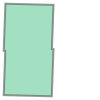

In [116]:
group_flight3(df,dates[3])

In [ ]:
flights = gpd.GeoDataFrame()
for date in dates:
    print(date)
    flight = group_flight(df,date)
    flights.append(flight)
flights

In [ ]:
flights.to_file(os.path.join(os.getcwd(),'training_set','aux_data'))

In [17]:
trial.append(trial)

/tmp/ipykernel_1482/1881502974.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trial.append(trial)


,geometry,date
0,"MULTIPOLYGON (((-120.81088 35.24746, -120.8783...",2018-09-13T00:00:00Z
0,"MULTIPOLYGON (((-120.81088 35.24746, -120.8783...",2018-09-13T00:00:00Z
